In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec

--2021-02-13 17:37:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1610017300 (1.5G) [binary/octet-stream]
Saving to: ‘wiki.ar.vec’

wiki.ar.vec         100%[===================>]   1.50G  24.4MB/s    in 64s     

2021-02-13 17:38:55 (24.1 MB/s) - ‘wiki.ar.vec’ saved [1610017300/1610017300]



In [ ]:
from gensim.models import KeyedVectors

In [ ]:
filepath = "wiki.ar.vec"
w2v = KeyedVectors.load_word2vec_format(filepath, binary=False)
print(len(w2v.vocab))

610977


In [ ]:
MAX_SEQUENCE_LENGTH = 85 #176 # based on our inputs; TODO: remove outliers? dynamically calculate!
MAX_NB_WORDS = len(w2v.vocab)
EMBEDDING_DIM = 300 # w2v, fastText; GloVe=50

In [ ]:
sample = w2v["حسن"]
print(sample.shape)
print(w2v.most_similar("حسن"))

(300,)
[('،حسن', 0.6795670390129089), ('أبوحسن', 0.6792263388633728), ('#حسن', 0.6771581172943115), ('وحسن', 0.6517007946968079), ('لحسن', 0.6505534648895264), ('\u200fحسن', 0.6446623206138611), ('كحسن', 0.6202388405799866), ('عبدالحسن', 0.6161733865737915), ('بوحسن', 0.6157495975494385), ('د/حسن', 0.6062546968460083)]


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
df = pd.read_csv('text.csv')
df.head()

,Tweet_id,Text,sentiment
0,1221875106206638080,@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...,Positive
1,1221884257490042887,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...",Neutral
2,1226422627436310528,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...,Positive
3,1221880820815798277,@Mo_Fat7 النهضة في فتيل 😂,Positive
4,1221884400377499651,@halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...,Neutral


In [ ]:
conditions = [
    (df['sentiment'] == 'Positive'),
    (df['sentiment'] == 'Negative'),
    (df['sentiment'] == 'Neutral'),
    ]
values = [0, 1, 2]
classes = ["Positive", "Negative", "Neutral"]
df['sentiment_classes'] = np.select(conditions, values)
df.head()

,Tweet_id,Text,sentiment,sentiment_classes
0,1221875106206638080,@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...,Positive,0
1,1221884257490042887,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...",Neutral,2
2,1226422627436310528,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...,Positive,0
3,1221880820815798277,@Mo_Fat7 النهضة في فتيل 😂,Positive,0
4,1221884400377499651,@halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...,Neutral,2


In [ ]:
df.drop('Tweet_id',1,inplace= True)
df.drop('sentiment',1,inplace= True)
df.head()

,Text,sentiment_classes
0,@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآ...,0
1,"""الزعل بيغير ملامحك ، بيغير نظرة العين ، بيغير...",2
2,الحب الحقيقي هو اقتسام بعض نفسك مع شخص أخر أقر...,0
3,@Mo_Fat7 النهضة في فتيل 😂,0
4,@halgawi @DmfMohe ليس حباً في ايران بقدر ماهو ...,2


In [ ]:
texts = list(df.Text)
labels = list(df.sentiment_classes)

In [ ]:
print('Found %s texts.' % len(texts))
print(texts[0], labels[0])

Found 32761 texts.
@nas_alharbi8 والله حسب الأرقام سيكون مخيب للآمال
ولكن الأهلي قدها برجاله في الملعب 💚🤍 0


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
MAX_NUM_WORDS = 200

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

print("sequence***", len(sequences[0]), sequences[0])
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

MAX_SEQUENCE_LENGTH = 1000

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

sequence*** 2 [45, 2]
Found 101363 unique tokens.
Shape of data tensor: (32761, 1000)
Shape of label tensor: (32761, 3)


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(data, labels, test_size=0.5, random_state=42)

In [ ]:
EMBEDDING_DIM = 300

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    if word in w2v.vocab:
        embedding_vector = w2v[word]
        embedding_vector = np.array(embedding_vector)
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

Preparing embedding matrix.
(200, 300)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.layers import Flatten
from keras.initializers import Constant

In [ ]:
print('Training model.')

# define the model
model = Sequential()
model.add(Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(3, activation='softmax'))


Training model.


In [ ]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
# summarize the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 300)         60000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 300000)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               153600512 
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=512,
          epochs=30,
          validation_data=(x_val, y_val))

Epoch 1/30
52/52 [==============================] - 18s 346ms/step - loss: 0.8715 - acc: 0.6771 - val_loss: 0.7154 - val_acc: 0.6992
Epoch 2/30
52/52 [==============================] - 18s 348ms/step - loss: 0.7015 - acc: 0.7055 - val_loss: 0.6852 - val_acc: 0.7048
Epoch 3/30
52/52 [==============================] - 18s 352ms/step - loss: 0.6826 - acc: 0.7050 - val_loss: 0.6705 - val_acc: 0.7150
Epoch 4/30
52/52 [==============================] - 18s 349ms/step - loss: 0.6475 - acc: 0.7237 - val_loss: 0.6611 - val_acc: 0.7134
Epoch 5/30
52/52 [==============================] - 18s 347ms/step - loss: 0.6118 - acc: 0.7378 - val_loss: 0.6369 - val_acc: 0.7338
Epoch 6/30
52/52 [==============================] - 18s 346ms/step - loss: 0.5699 - acc: 0.7565 - val_loss: 0.6320 - val_acc: 0.7410
Epoch 7/30
52/52 [==============================] - 18s 344ms/step - loss: 0.5359 - acc: 0.7693 - val_loss: 0.6189 - val_acc: 0.7548
Epoch 8/30
52/52 [==============================] - 18s 345ms/step - 

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)

print('Accuracy: %f' % (accuracy))
print('Loss: %f' % (loss))

512/512 [==============================] - 7s 14ms/step - loss: 0.1823 - acc: 0.9195
Accuracy: 0.919475
Loss: 0.182267


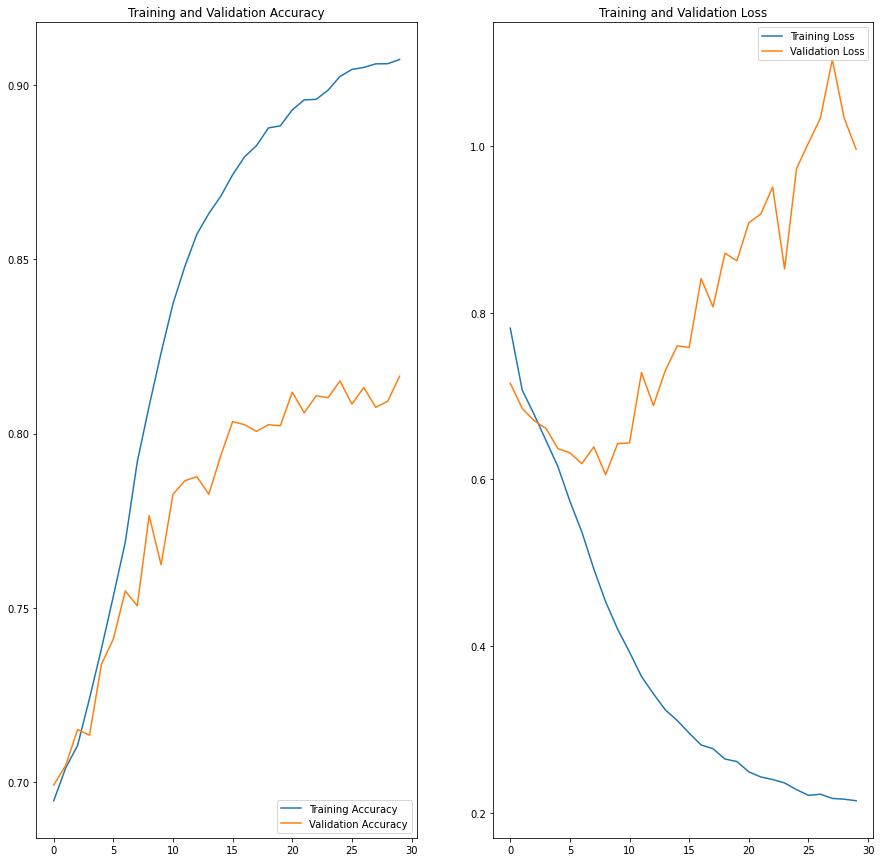

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(22)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('improved_model.h5')

In [ ]:
test_file = pd.read_csv('/content/test1_with_text.csv')
test_file.head()

In [ ]:
test_text = list(test_file.Text)
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(test_text)
sequences = tokenizer.texts_to_sequences(test_text)

print("sequence***", len(sequences[0]), sequences[0])
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

MAX_SEQUENCE_LENGTH = 1000

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)

sequence*** 5 [43, 102, 33, 32, 11]
Found 67700 unique tokens.
Shape of data tensor: (20000, 1000)


In [ ]:
predictions = np.argmax(model.predict(data), axis=1)
predictions[0]

1

In [ ]:
lp = list(predictions)
dframe=pd.DataFrame({'col1':lp})
dframe['Sentiment'] = 'NAN'
dframe.loc[(dframe['col1'] == 0), 'Sentiment'] = 'Positive'
dframe.loc[(dframe['col1'] == 1), 'Sentiment'] = 'Negative'
dframe.loc[(dframe['col1'] == 2), 'Sentiment'] = 'Neutral'
dframe = pd.concat([test_file, dframe], axis=1)
dframe.drop('col1',1,inplace=True)
dframe.to_csv('/content/test_file_prediction.csv', index=False)

In [ ]:
dt = pd.read_csv('test_file_prediction.csv')
dt.head()

,Tweet_id,Text,Sentiment
0,1251608623798722560,@kamnapp @bip_ksa @nazaha_gov_sa @MCgovSA شوفو...,Negative
1,1221535162539872256,\ربما الموت يقترب مني وانا لا اشعر به لطفك يا ...,Neutral
2,1252203833385779200,@mhrsd_care السلام عليكم\r\nلوسمحت تحديث ملف ا...,Neutral
3,1221884276636938240,”لقد نام تاركاً حلمهُ في ودائع الله فأيقظهُ ال...,Neutral
4,1252686719461273602,@nahdihope \r\nطالبه طلبيه منكم من امس ولحد ال...,Neutral
